<a href="https://colab.research.google.com/github/dilliraj1987/awesome-public-datasets/blob/master/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture 
!pip install pafy youtube-dl moviepy

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

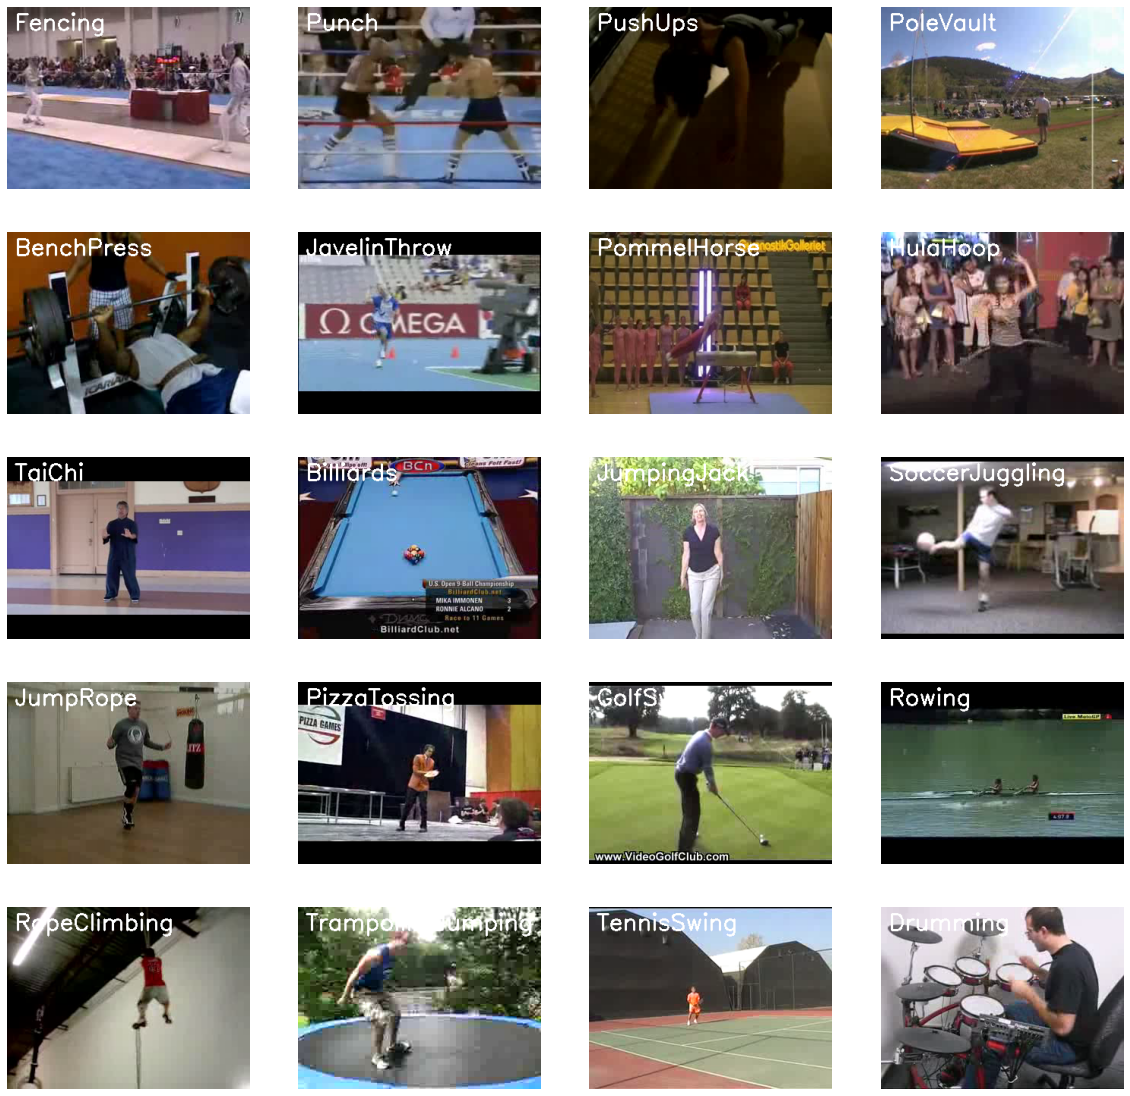

In [ ]:
plt.figure(figsize = (20,20))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)),20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
    selected_video_files_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_files_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

Preprocessing

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
CLASSES_LIST = ["TaiChi", "PullUps", "Rowing", "JumpRope"]

In [ ]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break
    
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()
  return frames_list

In [ ]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class: {class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)


  features = np.asarray(features)
  labels = np.array(labels)

  return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: TaiChi
Extracting Data of Class: PullUps
Extracting Data of Class: Rowing
Extracting Data of Class: JumpRope


In [ ]:
 one_hot_encoded_labels = to_categorical(labels)

Split Test and Train set

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

Implement CNN_LSTM

In [ ]:
def create_convlstm_model():
  model = Sequential()
  model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding = 'same', data_format = 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding = 'same', data_format = 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding = 'same', data_format = 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding = 'same', data_format = 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()

  return model

In [ ]:
convlstm_model = create_convlstm_model()
print("Model  Created Sucessfully")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

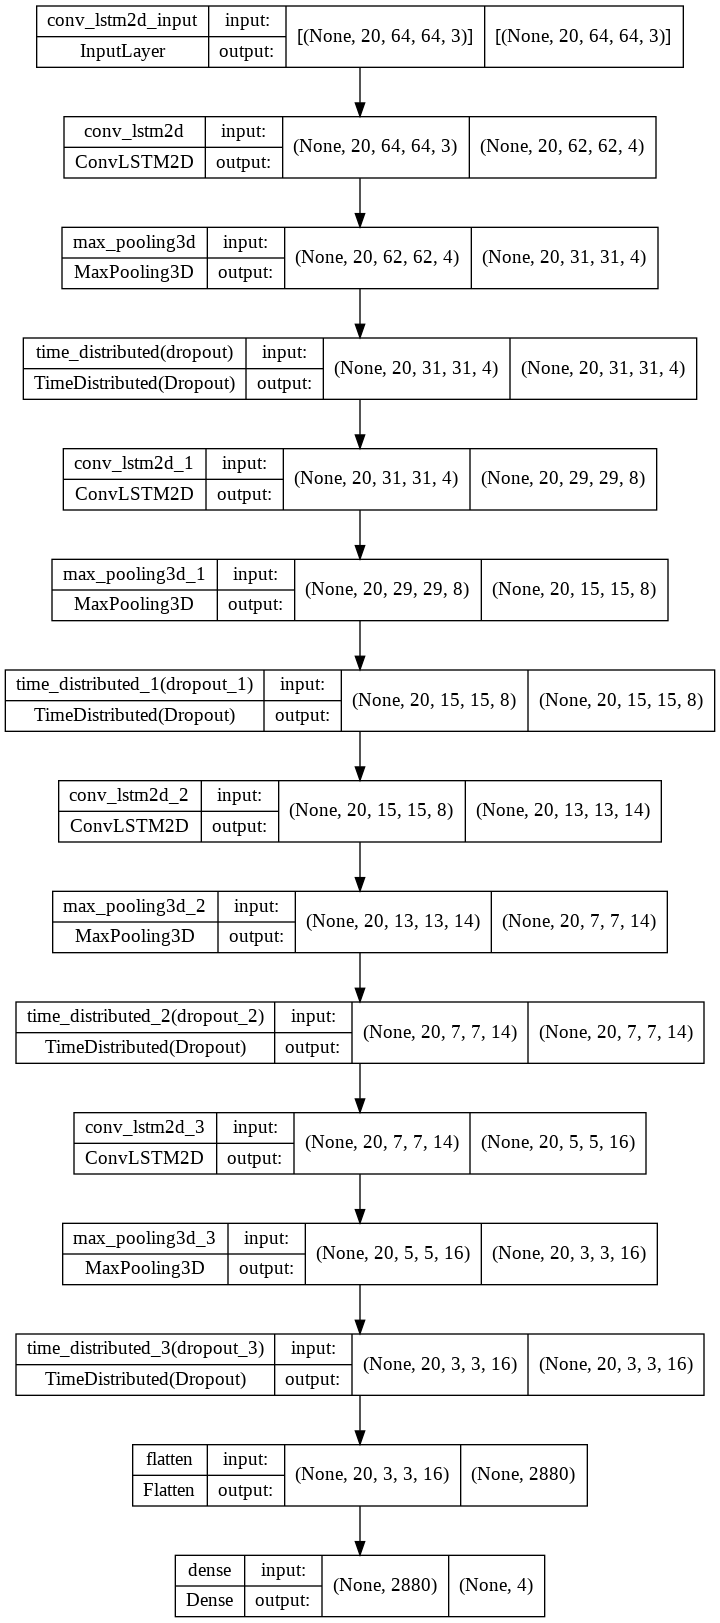

In [ ]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
76/76 [==============================] - 172s 2s/step - loss: 1.3743 - accuracy: 0.3146 - val_loss: 1.3157 - val_accuracy: 0.3553
Epoch 2/50
76/76 [==============================] - 155s 2s/step - loss: 1.2567 - accuracy: 0.4503 - val_loss: 1.2984 - val_accuracy: 0.4868
Epoch 3/50
76/76 [==============================] - 153s 2s/step - loss: 1.1213 - accuracy: 0.5464 - val_loss: 1.0374 - val_accuracy: 0.5789
Epoch 4/50
76/76 [==============================] - 152s 2s/step - loss: 0.8666 - accuracy: 0.6523 - val_loss: 0.6557 - val_accuracy: 0.7632
Epoch 5/50
76/76 [==============================] - 152s 2s/step - loss: 0.5419 - accuracy: 0.7914 - val_loss: 0.4993 - val_accuracy: 0.8026
Epoch 6/50
76/76 [==============================] - 153s 2s/step - loss: 0.3523 - accuracy: 0.8742 - val_loss: 0.3482 - val_accuracy: 0.8553
Epoch 7/50
76/76 [==============================] - 153s 2s/step - loss: 0.2784 - accuracy: 0.8841 - val_loss: 0.4572 - val_accuracy: 0.8553
Epoch 8/50
76

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 15s 3s/step - loss: 0.1201 - accuracy: 0.9528


In [ ]:
from inspect import currentframe
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

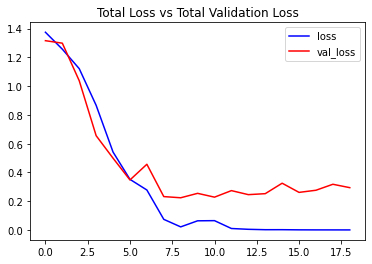

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

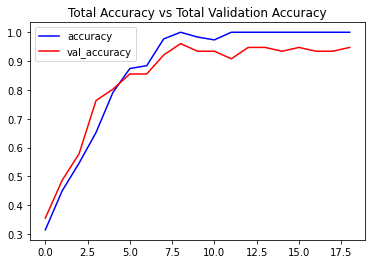

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Long Recurrent Convolutional Network (LRCN)

In [ ]:
def create_LRCN_model():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16,(3,3), padding = 'same', activation = 'relu'), 
                                   input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()

  return model

In [ ]:
LRCN_model = create_LRCN_model()
print("Model Created Successfully")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 4, 4, 32)    

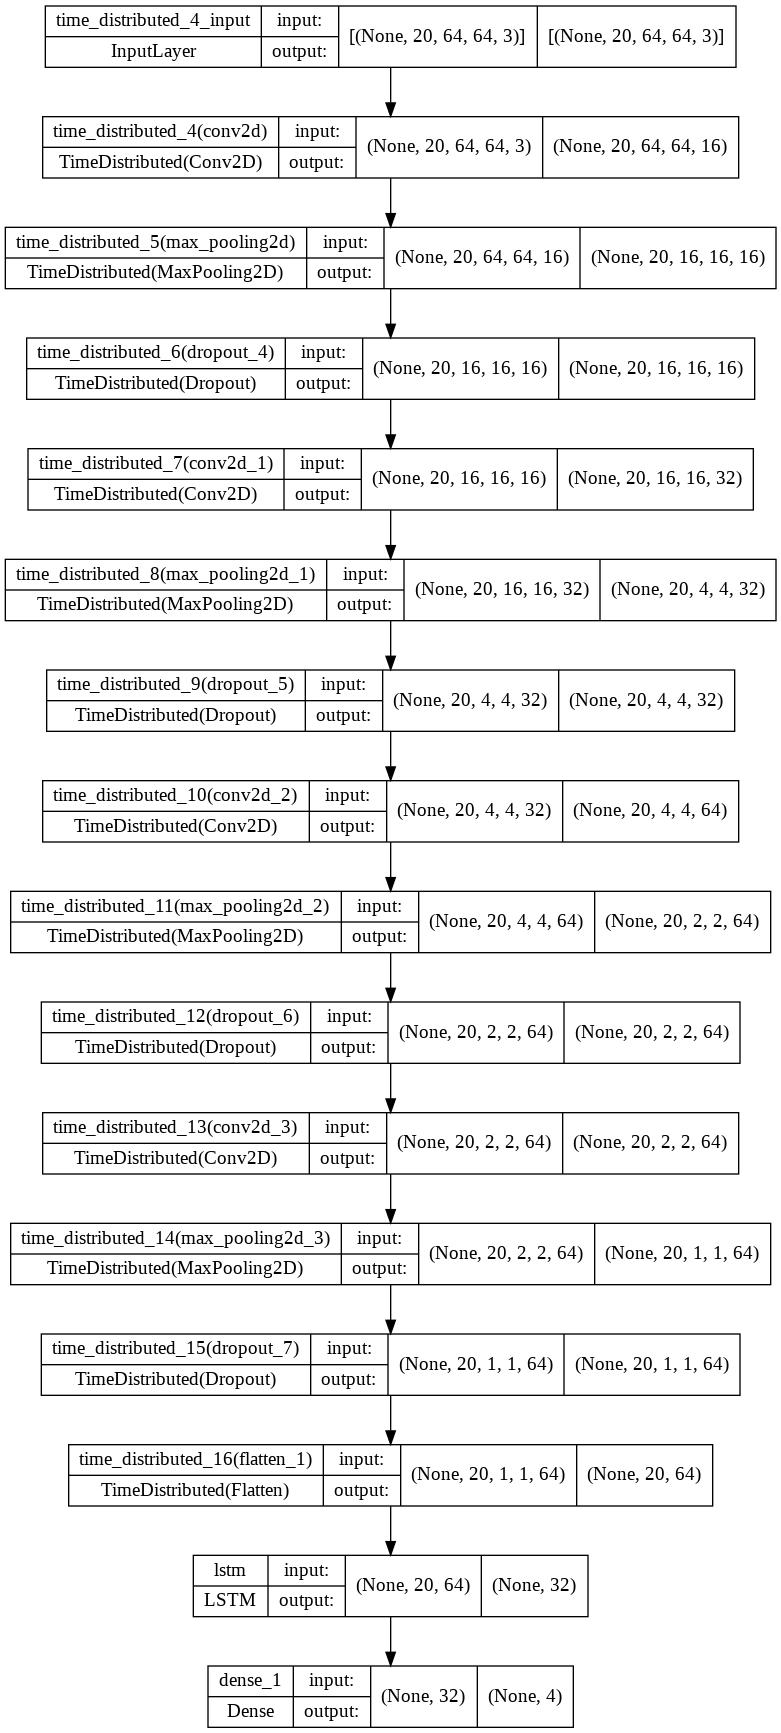

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/70
76/76 [==============================] - 18s 201ms/step - loss: 1.3932 - accuracy: 0.2848 - val_loss: 1.3672 - val_accuracy: 0.3421
Epoch 2/70
76/76 [==============================] - 14s 186ms/step - loss: 1.3732 - accuracy: 0.3079 - val_loss: 1.3476 - val_accuracy: 0.2500
Epoch 3/70
76/76 [==============================] - 14s 187ms/step - loss: 1.2511 - accuracy: 0.3907 - val_loss: 1.0799 - val_accuracy: 0.5132
Epoch 4/70
76/76 [==============================] - 14s 187ms/step - loss: 0.9847 - accuracy: 0.5596 - val_loss: 0.9125 - val_accuracy: 0.6053
Epoch 5/70
76/76 [==============================] - 15s 192ms/step - loss: 0.8731 - accuracy: 0.5728 - val_loss: 0.8787 - val_accuracy: 0.5526
Epoch 6/70
76/76 [==============================] - 14s 186ms/step - loss: 0.7981 - accuracy: 0.6556 - val_loss: 0.8735 - val_accuracy: 0.6447
Epoch 7/70
76/76 [==============================] - 14s 186ms/step - loss: 0.6970 - accuracy: 0.6921 - val_loss: 0.5837 - val_accuracy: 0.8026

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 422ms/step - loss: 0.2097 - accuracy: 0.9449


In [ ]:
from inspect import currentframe
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
LRCN_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, '-.r*', label = metric_name_1)
  plt.plot(epochs, metric_value_2, '-.bo', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

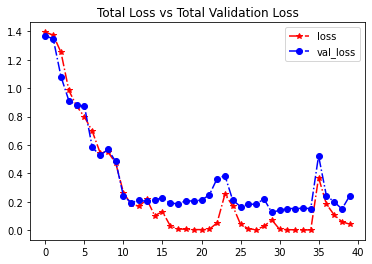

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

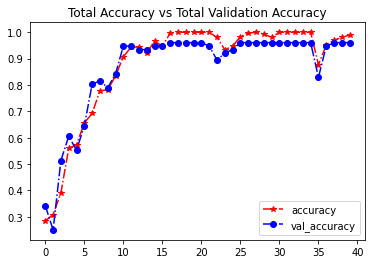

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def create_DenseNet_model():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(8,(3,3), padding = 'same', activation = 'relu'), 
                                   input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(16,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()
  return model

In [ ]:
DenseNet_model = create_DenseNet_model()
print("Model Created Successfully")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_65 (TimeDi  (None, 20, 64, 64, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 20, 32, 32, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 20, 32, 32, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 20, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 20, 8, 8, 16)    

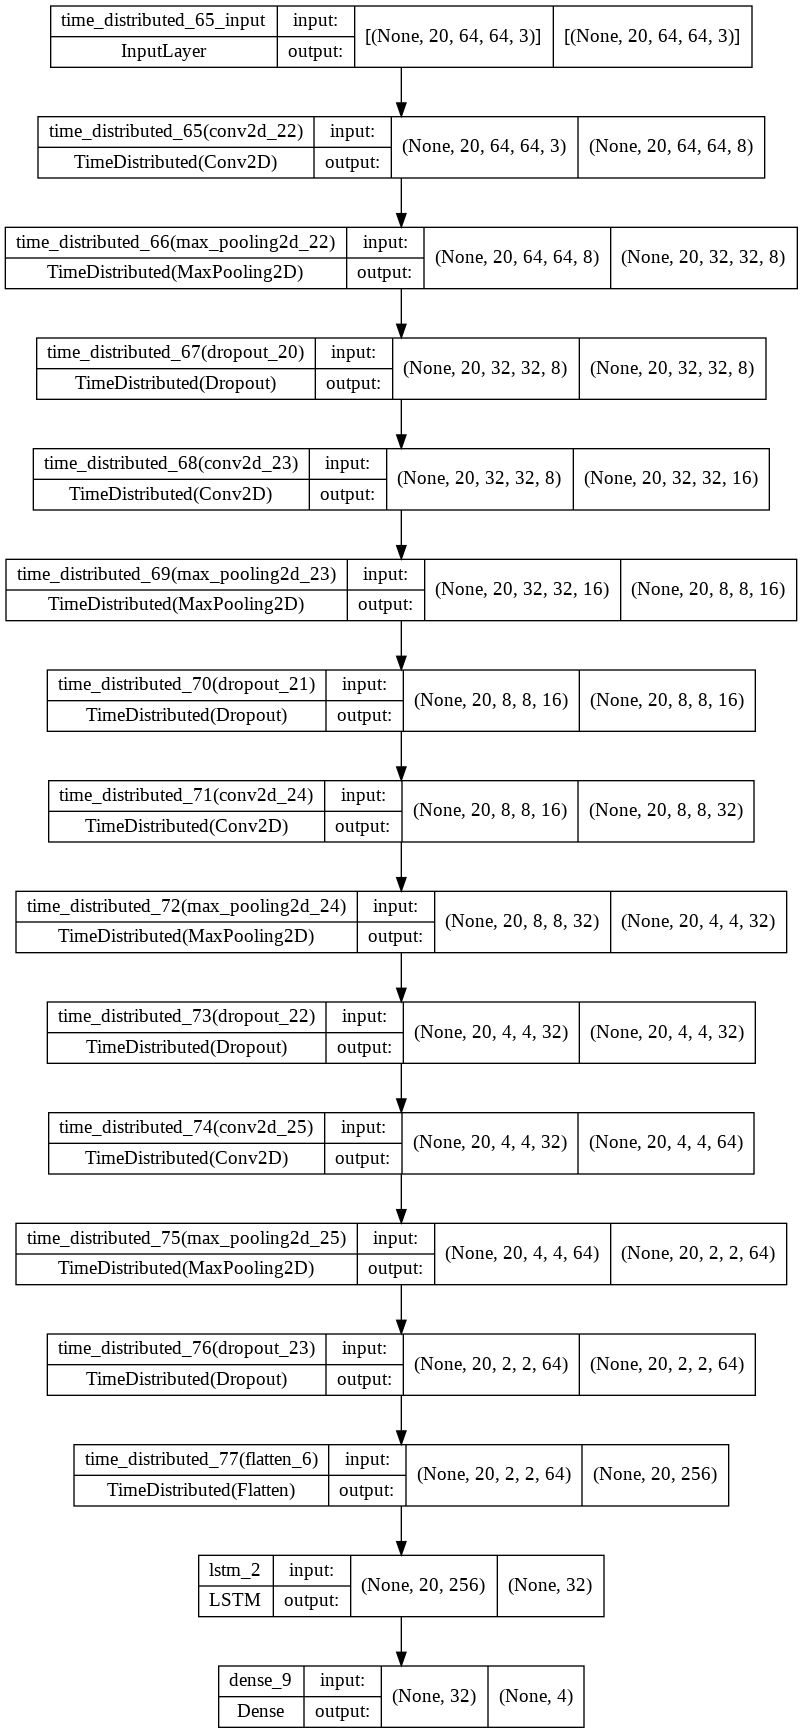

In [ ]:
plot_model(DenseNet_model, to_file = 'DenseNet_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
DenseNet_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

DenseNet_model_training_history = DenseNet_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/30
76/76 [==============================] - 19s 216ms/step - loss: 1.3965 - accuracy: 0.2583 - val_loss: 1.3657 - val_accuracy: 0.3421
Epoch 2/30
76/76 [==============================] - 16s 205ms/step - loss: 1.3572 - accuracy: 0.2947 - val_loss: 1.2732 - val_accuracy: 0.4868
Epoch 3/30
76/76 [==============================] - 16s 205ms/step - loss: 1.0977 - accuracy: 0.5298 - val_loss: 0.8142 - val_accuracy: 0.6842
Epoch 4/30
76/76 [==============================] - 16s 205ms/step - loss: 0.9408 - accuracy: 0.6060 - val_loss: 0.7438 - val_accuracy: 0.7632
Epoch 5/30
76/76 [==============================] - 16s 214ms/step - loss: 0.7473 - accuracy: 0.7152 - val_loss: 0.6274 - val_accuracy: 0.8158
Epoch 6/30
76/76 [==============================] - 16s 206ms/step - loss: 0.5767 - accuracy: 0.7748 - val_loss: 0.4867 - val_accuracy: 0.8158
Epoch 7/30
76/76 [==============================] - 16s 207ms/step - loss: 0.4529 - accuracy: 0.8510 - val_loss: 0.3903 - val_accuracy: 0.8553

In [ ]:
model_evaluation_history = DenseNet_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 451ms/step - loss: 0.2111 - accuracy: 0.9213


In [ ]:
from inspect import currentframe
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'DenseNet_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
DenseNet_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, '-.r*', label = metric_name_1)
  plt.plot(epochs, metric_value_2, '-.bo', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

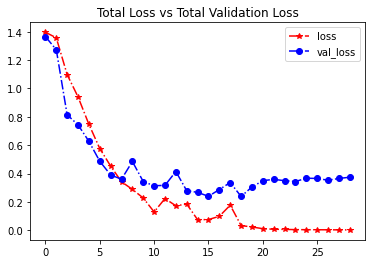

In [ ]:
plot_metric(DenseNet_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

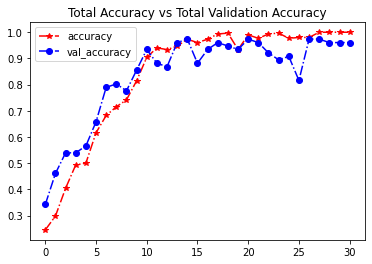

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
  video = pafy.new(youtube_video_url)
  title = video.title
  video_best = video.getbest()
  output_file_path = f'{output_directory}/{title}.mp4'
  video_best.download(filepath = output_file_path, quiet = True)
  return title

In [ ]:
!pip uninstall -y pafy

Found existing installation: pafy 0.5.5
Uninstalling pafy-0.5.5:
  Successfully uninstalled pafy-0.5.5


In [ ]:
!pip install git+https://github.com/Cupcakus/pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Cupcakus/pafy to /tmp/pip-req-build-jnjypr8d
  Running command git clone -q https://github.com/Cupcakus/pafy /tmp/pip-req-build-jnjypr8d
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35757 sha256=0b1a342ebf04927a8fa4444e8c8e23ed2778b96f16a977cb6ec0752491d8d80c
  Stored in directory: /tmp/pip-ephem-wheel-cache-207at19g/wheels/93/1a/52/3c75e2f35b4aac122bcb0a64c08339224a76eafef3f150b9db
Successfully built pafy


In [ ]:
!pip install youtube-dl==2020.12.2
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

video_title = download_youtube_videos('https://youtu.be/8u0qjmHIOcE', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
  video_reader = cv2.VideoCapture(video_file_path)
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M','P','4','V'),
                                 video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
  frames_queue = deque(maxlen = SEQUENCE_LENGTH)
  predicted_class_name = ''
  while video_reader.isOpened():
    ok, frame = video_reader.read()
    if not ok:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_queue.append(normalized_frame)
    if len(frames_queue) == SEQUENCE_LENGTH:
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0)) [0]
      predicted_labels = np.argmax(predicted_labels_probabilities)
      predicted_class_name = CLASSES_LIST[predicted_label]

    cv2.putText(frame, predicted_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    video_writer.write(frame)
  video_reader.release()
  video_writer.release()
 

  

In [ ]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
videoFlipClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

NameError: ignored